In [1]:
# Import dependencies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers

# Utilities

In [2]:
def plot_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = ((len(images)-1) // n_cols) + 1 

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
        
    plt.figure(figsize=(n_cols, n_rows))
    
    for idx, img in enumerate(images):
        plt.subplot(n_rows, n_cols, idx+1)
        plt.imshow(img, cmap="binary")
        plt.axis(False)

# Download and Prepare the Dataset

In [3]:
# Load the training set of the MNIST dataset
(X_train, _), _ = tf.keras.datasets.mnist.load_data()

# Normalize pixels values
X_train = np.float32(X_train) / 255.0

# Create batches of train images
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=len(dataset))
dataset = dataset.batch(128, drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

11490434/11490434 [==============================] - 1s 0us/step


# Model Engineering

## Generator

The generator takes in random noise and uses it to create fake images.

In [4]:
noise_dim = 32 # shape of the noise input

# Generator model
generator = tf.keras.models.Sequential([
    layers.Dense(units=64, activation="selu", input_shape=[noise_dim]),
    layers.Dense(units=128, activation="selu"),
    layers.Dense(units=28*28, activation="sigmoid"),
    layers.Reshape([28, 28])
])

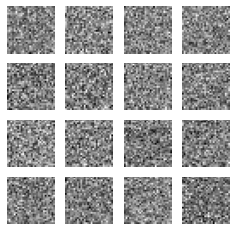

In [5]:
# Get sample output from the untrained generator
test_noise = tf.random.normal([16, noise_dim])
test_images = generator(test_noise)
plot_images(test_images, n_cols=4)

## Discriminator

The discriminator takes in the input (fake or real) images and determines if it is fake or not.

In [6]:
# Discriminator model
discriminator = tf.keras.models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(128, activation="selu"),
    layers.Dense(64, activation="selu"),
    layers.Dense(1, activation="sigmoid")
])

In [7]:
# Initialize the model
gan_model = tf.keras.models.Sequential([generator, discriminator])

# Get model summary
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28)            111568    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 108801    
                                                                 
Total params: 220,369
Trainable params: 220,369
Non-trainable params: 0
_________________________________________________________________


# Compile the Model

In [8]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan_model.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Train the Model

The training loop consists of **two** phases : 
> **Phase 1** trains the discriminator to distinguish between fake or real data.

> **Phase 2** trains the generator to generate images that will trick the discriminator.

In [14]:
N_EPOCHS = 30
BATCH_SIZE = 128

In [19]:
def train_gan_model(gan_model, dataset, noise_dim=32):
    # Get the two sub-networks (generator & discriminator) from the GAN model
    generator, discriminator = gan_model.layers

    # Loop through each epoch
    for epoch in range(N_EPOCHS):
        # Loop through each batch in the dataset
        for idx, real_images in enumerate(dataset):
            # Get the batch size
            batch_size = real_images.shape[0]

            ## PHASE 1 : Train the discriminator 
            # Create the noise
            noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim))
            # Use the noise to generate fake images
            fake_images = generator(noise)
            # Concatenate fake images with real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            # Create the labels for the discriminator, 0 -> fake image ; 1 -> real image
            discriminator_labels = tf.concat([tf.constant([[0.]] * BATCH_SIZE), tf.constant([[1.]] * BATCH_SIZE)], axis=0)
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            # print(idx, mixed_images.shape, discriminator_labels.shape)
            # Train the discriminator
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            ## PHASE 2 : Train the generator
            # Create a batch of noisy input to feed to the GAN model
            noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim))
            # Label all generated images with 1 (real image)
            generator_labels = tf.constant([[1.]] * BATCH_SIZE)
            # Freeze the discriminator
            discriminator.trainable = False
            # Train the GAN model
            gan_model.train_on_batch(noise, generator_labels)

        # Plot the fake images used to train the discriminator
        if ((epoch+1) % 5) == 0:
            print(f"\nEpoch {epoch+1}/{N_EPOCHS} :")
            plot_images(fake_images, 8)                     
            plt.show() 


Epoch 5/30 :


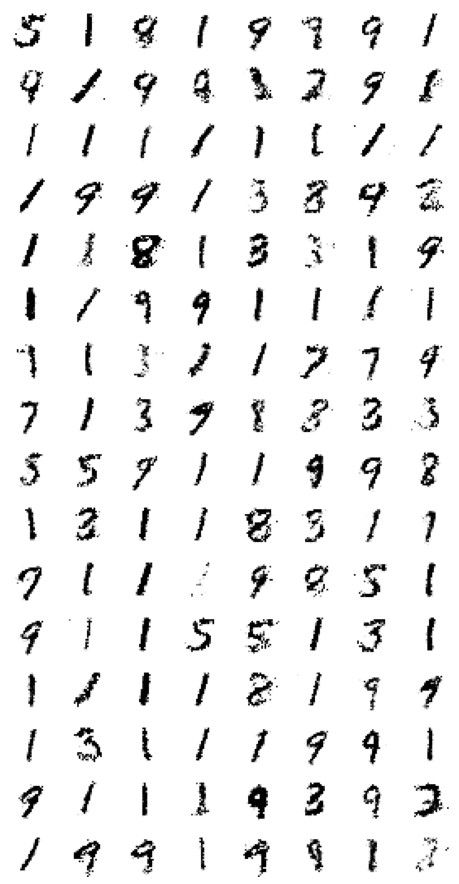


Epoch 10/30 :


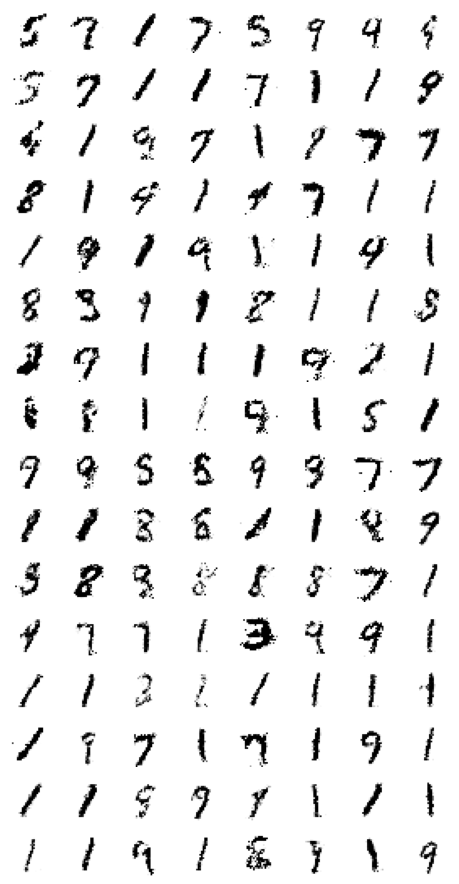


Epoch 15/30 :


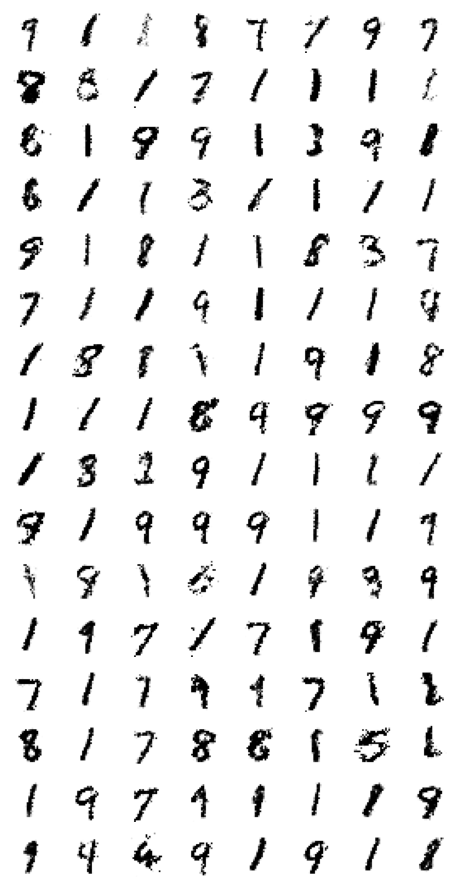


Epoch 20/30 :


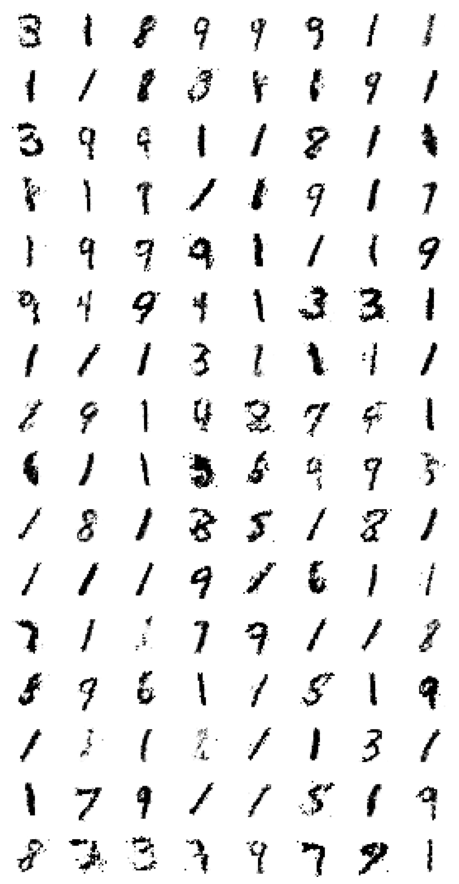


Epoch 25/30 :


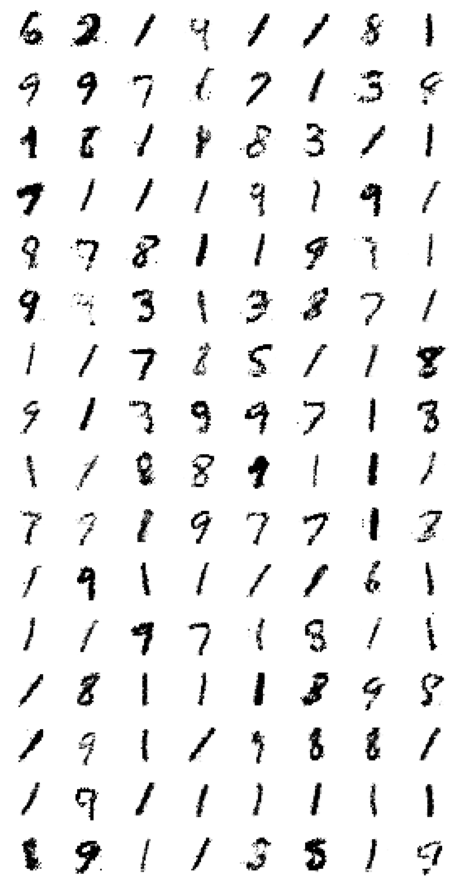


Epoch 30/30 :


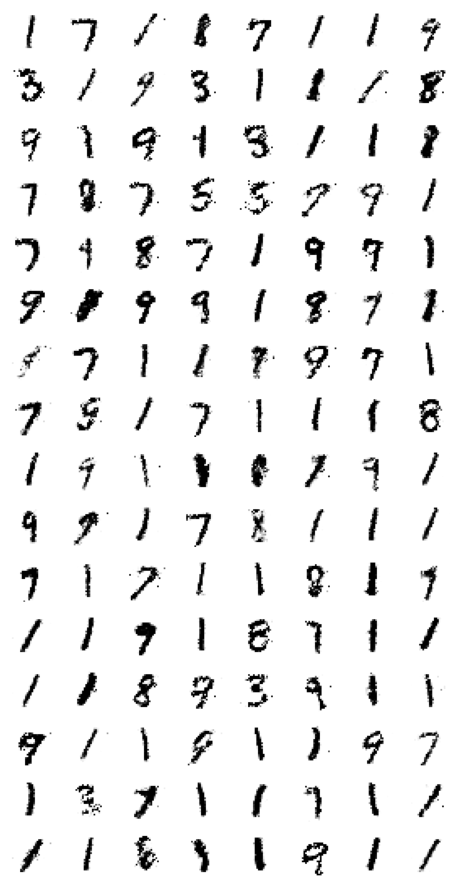

In [20]:
# Train the model
train_gan_model(gan_model, dataset, noise_dim)